# Introduction

## Motivations
The concept of our project originated from adding complexity to a random walk on $\mathbb{Z}$. We wanted to investigate adding some 'momentum' to a Markov jump process, by developing a process that increases at a faster rate if it is already increasing, and decreases at a faster rate if it is already decreasing.

The main problem with this is that a process which remembers the past two steps, as opposed to only the last step, does not strictly satisfy the Markov property as we have used it in lectures. However, we can simulate it as a two-dimensional process, whose first component is the current step, and whose second component is the subsequent step. This is indeed a Markov jump process.

## Notation

Let $E\subset\mathbb{Z}^2$ be the set of pairs $(x,y)$ such that $y\in\{x+1,x-1\}$. We define $E_\uparrow\subset E$ to be the set $\{(x,y)\in E:y=x+1\}$, and similarly define $E_\downarrow\subset E$ as $\{(x,y)\in E:y=x-1\}$.

For all $x\in\mathbb{Z}$, we write $x_\uparrow$ to mean the point $(x,x+1)\in E$, that is the movement of the random walk from $x$ to $x+1$, and similarly write $x_\downarrow$ to mean the point $(x,x-1)\in E$.

## Construction

Let $(X_t)_{t\geq0}$ be a Markov jump process, taking values in $E$, with infinitesimal generator $Q$ and jump process $(T_n)_{n\in\mathbb{N}}$. Given $\alpha,\beta,\eta,\gamma>0$, we construct $Q$ as follows.

For $x\geq0$:
*   $Q(x_\uparrow,x+1_\uparrow)=\alpha$
*   $Q(x_\uparrow,x+1_\downarrow)=\beta=-Q(x_\uparrow,x_\uparrow)-\alpha$

For $x>1$:
*   $Q(x_\downarrow,x-1_\downarrow)=\eta$
*   $Q(x_\downarrow,x-1_\uparrow)=\gamma=-Q(x_\downarrow,x_\downarrow)-\eta$

For $x\leq0$:
*   $Q(x_\downarrow,x-1_\downarrow)=\alpha$
*   $Q(x_\downarrow,x-1_\uparrow)=\beta=-Q(x_\downarrow,x_\downarrow)-\alpha$

For $x<-1$:
*   $Q(x_\uparrow,x+1_\uparrow)=\eta$
*   $Q(x_\uparrow,x+1_\downarrow)=\gamma=-Q(x_\uparrow,x_\uparrow)-\eta$

Special cases of movement into $0$:
*   $Q(1_\downarrow,0_\downarrow)=\alpha$
*   $Q(1_\downarrow,0_\uparrow)=\gamma=-Q(1_\downarrow,1_\downarrow)-\alpha$
*   $Q(-1_\uparrow,0_\uparrow)=\alpha$
*   $Q(-1_\uparrow,0_\downarrow)=\gamma=-Q(-1_\uparrow,-1_\uparrow)-\alpha$

For all other pairs $p,q\in E$, we set $Q(p,q)=0$.


On the positive numbers, $\alpha$ represents the rate of continuing upwards given that the previous step was an upward movement (away from $0$), while $\beta$ represents the rate of moving downwards given a previous upward movement. In other words, given that the previous step was upwards, the probability of continuing upwards is $\frac{\alpha}{\alpha+\beta}$.

Similarly, given that the previous step was a downward movement, we set the rate of continuing downwards to $\eta$ and the rate of moving upwards to $\gamma$.

To extend this onto all of $E$ including negative values, we reflect around $0$, swapping upwards and downwards movement. This creates an exceptional case at $0$, which we chose to model slightly differently. If, for example, the process moves down from $1$ to $0$ (the point $1_\downarrow$), continuing down to $-1$ is seen as continuing away from $0$, and has rate $\alpha$. If the process moves to $0$ and turns around again, such as from $1_\downarrow$ to $0_\uparrow$, this is seen as a switching of direction and is assigned rate $\gamma$.

We choose $X_0$ uniformly between $0_\uparrow$ and $0_\downarrow$.

In this notebook we will focus on the special case $\alpha=\gamma^{2}$ and $\eta=\beta^{2}$ having $1<\gamma<\beta$. This means the movement with momentum is the square of the movement without momentum. Moreover $\gamma<\beta$ ensures that the movement towards $0$ is stronger than the movement outward from $0$, which is crucial for the positive recurrence that we will prove later.

Note that we still use the more general notation in the python script and in all proofs except in the proof of positive recurrence.

# Initializing Process

Next, we simulate the process $(X_t)_{t\geq0}$. We use that the jump times are independent exponentially distributed, with exponential parameter depending on the current state.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Initializing Parameters
beta=3
gamma=2
alpha=gamma**2
eta=beta**2

In [ ]:
# Initializing Q

#read Q((x,y),(z,w))
def Q(x,y,z,w):
  if y==0 and (x==1 or x==-1):
    if z==x and y==w:
      return -alpha -gamma
    if y==z and w==-x:
      return alpha
    if y==z and w==x:
      return gamma

  if y==x+1 and x>=0:
    if x==z and y==w:
      return -alpha-beta
    if y==z:
      if w==z+1:
        return alpha
      if w==z-1:
        return beta

  if y==x-1 and x<=0:
    if x==z and y==w:
      return -alpha-beta
    if y==z:
      if w==z-1:
        return alpha
      if w==z+1:
        return beta

  if y==x-1 and x>=2:
    if x==z and y==w:
      return -eta-gamma
    if y==z :
      if w==z-1:
        return eta
      if w==z+1:
        return gamma

  if y==x+1 and x<=-2:
    if x==z and y==w:
      return -eta-gamma
    if y==z:
      if w==z+1:
        return eta
      if w==z-1:
        return gamma
  return 0

In [ ]:
# probability of moving from state x to state y
# here x and y are tuples in E. we require that x's second state is y's first state, ie. they are consecutive
def P(x,y):
  if x[1]==y[0]:
    return Q(x[0],x[1],y[0],y[1])/(-Q(x[0],x[1],x[0],x[1]))

In [ ]:
# returns the tuples and the jump times for the first n jumps
def X(n=100):
  # decide first step
  h=np.random.binomial(1,1/2)
  Z=[(0,(-1)**h)]

  # at each step x=(x[0],x[1]), the walk moves up with probability P(x,(x[1],x[1]+1))
  p=np.random.uniform(size=n)
  for i in range(n):
    y=Z[i][1]
    p_up=P(Z[i],(y,y+1))
    if p[i]<p_up:
      Z.append((y,y+1))
    else:
      Z.append((y,y-1))

  # calculates exponential parameters and random variables
  betas=[-1/Q(x[0],x[1],x[0],x[1]) for x in Z]
  jump_intervals=np.random.exponential(scale=betas)
  jumps=list(np.cumsum(jump_intervals))
  return Z,[0]+jumps

Here is a one dimensional representation of X:

Text(0.5, 0, 'time')

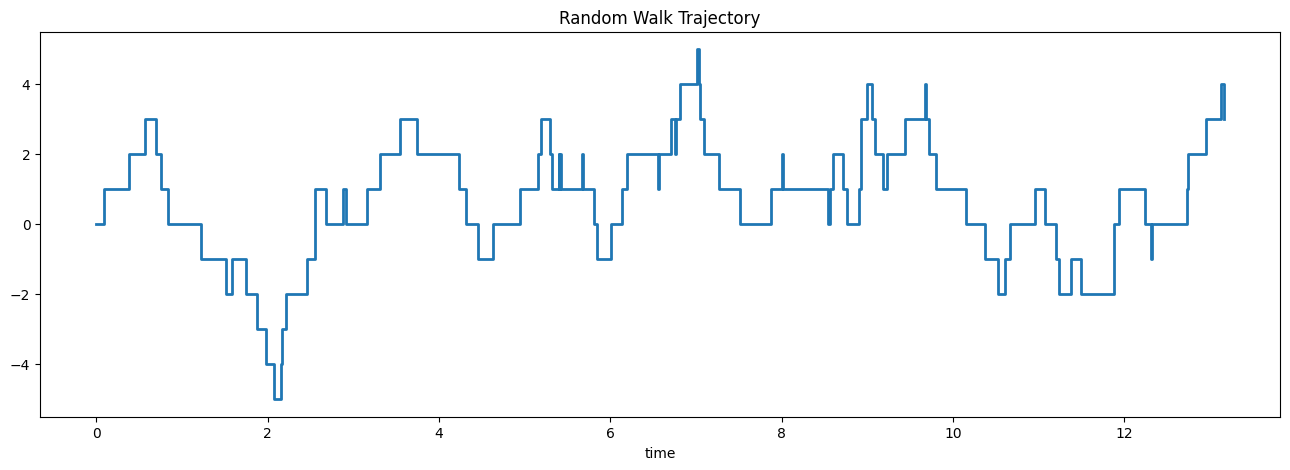

In [ ]:
n = int(1e2)
Z, jumps = X(n)

# reformats Z to a list of single points the same length as jumps
events = [0]+[Z[i][1] for i in range(len(Z))]

#plot the random walk
fig, ax = plt.subplots(figsize=(16, 5))
ax.step(jumps, events, where="post", linewidth=2.0)
ax.set_title("Random Walk Trajectory", fontsize=12)
ax.set_xlabel("time")

# Proof of Stationary Measure

The main goal of this project is to identify, and prove uniqueness of (up to a constant), a stationary measure for $(X_t)_{t\geq0}$. We begin by proving some preliminary statements.

## Irreducibility

For all $p\in E$, we have that $\lambda(p)=-Q(p,p)>0$, and so the process has no absorbing states. Consequently, we can define the Markov chain $(Z_n)_{n\in\mathbb{N}}:= (X_{T_n})_{n\in\mathbb{N}}$. It has transition matrix $P$, meaning that for all $p,q\in E$, $P(p,q)=\mathbb{P}(Z_1=q\ |\ Z_0=p)$. We now want to prove that this is an irreducible Markov chain.

For all $x_\uparrow\in E_\uparrow$, $P(x_\uparrow,x+1_\uparrow)>0$ and $P(x_\uparrow,x+1_\downarrow)>0$, while for all $x_\downarrow\in E_\downarrow$, $P(x_\downarrow,x-1_\uparrow)>0$ and $P(x_\downarrow,x-1_\downarrow)>0$. We let $x,y\in \mathbb{R}$ with $x<y$, and reduce the problem to showing the following four cases:


1.   $x_\uparrow\rightarrow x_\downarrow$:

    $$\mathbb{P}(Z_2=x_\downarrow\ |\ Z_0=x_\uparrow)=\mathbb{P}(Z_2=x_\downarrow,Z_1=x+1_\downarrow\ |\ Z_0=x_\uparrow)=P(x_\uparrow,x+1_\downarrow)P(x+1_\downarrow,x_\downarrow)>0.$$
2.   $x_\downarrow\rightarrow x_\uparrow$:

    $$\mathbb{P}(Z_2=x_\uparrow\ |\ Z_0=x_\downarrow)=\mathbb{P}(Z_2=x_\uparrow,Z_1=x-1_\uparrow\ |\ Z_0=x_\downarrow)=P(x_\downarrow,x-1_\uparrow)P(x-1_\uparrow,x_\uparrow)>0.$$
3.  $x_\uparrow\rightarrow y_\uparrow$:

    $$\mathbb{P}(Z_{y-x}=y_\uparrow\ |\ Z_0=x_\uparrow) = P(x_\uparrow,x+1_\uparrow)P(x+1_\uparrow,x+2_\uparrow)\ldots P(y-1_\uparrow,y_\uparrow)>0.$$
4.  $y_\downarrow\rightarrow x_\downarrow$:

    $$\mathbb{P}(Z_{y-x}=x_\downarrow\ |\ Z_0=y_\downarrow)=P(y_\downarrow,y-1_\downarrow)P(y-1_\downarrow,y-2_\downarrow)\ldots P(x+1_\downarrow,x_\downarrow)>0.$$

Irreducibility of $(Z_n)_{n\in\mathbb{N}}$ follows immediately from transitivity, and so by definition $(X_t)_{t\geq0}$ is irreducible.

## Non-Explosivity

We want to show that $\lim_{n\rightarrow\infty}T_n = +\infty$ a.s. This is equivalent to showing that
$$\sum_{n=0}^\infty \frac{1}{\lambda(Z_n)}=+\infty\ \text{a.s.}$$

Now for all $p\in E$, $\lambda(p)=-Q(p,p)$. But $-Q(p,p)\in\{\alpha+\beta,\eta+\gamma,\alpha+\gamma\}\subset\mathbb{R}_{>0}$. So
$$\sum_{n=0}^\infty \frac{1}{\lambda(Z_n)} \geq \sum_{n=0}^\infty \frac{1}{\min\{\alpha+\beta,\eta+\gamma,\alpha+\gamma\}}=+\infty.$$

## Positive Reccurence

We will show that the Lyapunov criterion holds in the particular case described above, i.e. $\alpha=\gamma^{2}$ and $\eta=\beta^{2}$.
We remind that since $X$ is an irreducible, non-explosive Markov process, we need to find a $V:E\rightarrow \mathbb{R}_{+}$, a finite $F\subset E$ and $a,b>0$ such that for all $p\in E$,
$$\sum_{q\in E} Q(p,q)(V(q)-V(p))\leq-a+b \mathbf{1}_{q\in F}
$$
We start by considering $p=x_\uparrow$ or $x_\downarrow$ where $x>1$. We can distinguish two cases of the right-hand side of the above equation:



*   $$\sum_{q\in E} Q(x_\uparrow,q)(V(q)-V(x_\uparrow)\ =
    Q(x_\uparrow,x+1_\uparrow)(V(x+1_\uparrow)-V(x_\uparrow))+Q(x_\uparrow,x+1_\downarrow)(V(x+1_\downarrow)-V(x_\uparrow)) \\
    =\alpha(V(x+1_\uparrow)-V(x_\uparrow))+\beta(V(x+1_\downarrow)-V(x_\uparrow))
    $$

*   $$\sum_{q\in E} Q(x_\downarrow,q)(V(q)-V(x_\downarrow)\ =
    Q(x_\downarrow,x-1_\downarrow)(V(x-1_\downarrow)-V(x_\downarrow))
    +Q(x_\downarrow,x-1_\uparrow)(V(x-1_\uparrow)-V(x_\downarrow)\\
    = \eta(V(x-1_\downarrow)-V(x_\downarrow))
    +\gamma(V(x-1_\uparrow)-V(x_\downarrow))
    $$



Using $V(x_\uparrow)=x+\beta$ and $V(x_\downarrow)=x-1$, as well as our assumptions on $\alpha$ and $\eta$, we get the following expressions.
$$
\begin{aligned}
&\begin{cases}
    \gamma^{2}(V(x+1_\uparrow)-V(x_\uparrow))+\beta(V(x+1_\downarrow)-V(x_\uparrow)) \\
    \beta^{2}(V(x-1_\downarrow)-V(x_\downarrow))
    +\gamma(V(x-1_\uparrow)-V(x_\downarrow))
\end{cases}\\
=&
\begin{cases}
    \gamma^{2}(x+1+\beta-x-\beta)+\beta(x+1-1-x-\beta) \\
    \beta^{2}(x-1-1-(x-1))
    +\gamma(x-1+\beta-(x-1))
\end{cases}\\
=&
\begin{cases}
    \gamma^{2}-\beta^{2} \\
    -\beta^{2}
    +\gamma\beta
\end{cases}
\end{aligned}
$$
Since $\beta>\gamma>1$, in both cases,
$$
\sum_{q\in E} Q(p,q)(V(q)-V(p))\leq -(\beta-\gamma)
$$
Since $Q$ is symetric around $0$, we can get the very same inequality for $x<-1$ and $V(x_\uparrow)=-x_\downarrow$, $V(x_\downarrow)=-x_\uparrow$. So $a=\beta-\gamma>0$. The choice of $F=\left\{0_\uparrow,0_\downarrow,1_\downarrow,1_\uparrow,-1_\downarrow,-1_\uparrow\right\}$ and $b=a+\sup_{p\in F}\sum_{q\in E} Q(p,q)(V(q)-V(p))$ then gives us the desired inequality for all states of $E$.

## Stationary Measure Calculation

We have shown that $(X_t)_{t\geq0}$ is irreducible, non-explosive, and positive recurrant. As a result, it admits a unique (up to a constant) invariant measure $\pi$, which satisfies $\pi Q=0$. We solve this to obtain a formula for $\pi$.

We assume without proof that due to the symmetrical construction of our MJP, $\pi(x_\uparrow)=\pi(-x_\downarrow)$ for all $x\in\mathbb{Z}$.

Since the measure is unique up to scaling, we can set $\pi(0_\uparrow)=1$ and scale other values accordingly. The following computation establishes a relation between $\pi(0_\uparrow)$ and $\pi(1_\downarrow)$:

$$0=\pi Q(0_\uparrow)=\pi(-1_\uparrow)Q(-1_\uparrow,0_\uparrow)+\pi(1_\downarrow)Q(1_\downarrow,0_\uparrow)+\pi(0_\uparrow)Q(0_\uparrow,0_\uparrow)$$
$$=\pi(1_\downarrow)\alpha + \pi(1_\downarrow)\gamma-\pi(0_\uparrow)(\alpha+\beta)\text{ by symmetry}.$$
This gives $$\pi(1_\downarrow)=\frac{\alpha+\beta}{\alpha+\gamma}\pi(0_\uparrow).$$

Next, we have
$$0=\pi Q(1_\downarrow)=\pi(0_\uparrow)Q(0_\uparrow,1_\downarrow)+\pi(2_\downarrow)Q(2_\downarrow,1_\downarrow)+\pi(1_\downarrow)Q(1_\downarrow,1_\downarrow)$$
$$=\pi(0_\uparrow)\beta+\pi(2_\downarrow)\eta-\pi(1_\downarrow)(\alpha+\gamma).$$
This gives $$\pi(2_\downarrow)=\frac{-\beta}{\eta}\pi(0_\uparrow)+\frac{\alpha+\gamma}{\eta}\pi(1_\downarrow).$$



Again using $\pi Q=0$, we have
$$-\pi(x_\uparrow)Q(x_\uparrow,x_\uparrow)=\pi(x-1_\uparrow)Q(x-1_\uparrow,x_\uparrow)+\pi(x+1_\downarrow)Q(x+1_\downarrow,x_\uparrow),$$
$$-\pi(x_\downarrow)Q(x_\downarrow,x_\downarrow)=\pi(x-1_\uparrow)Q(x-1_\uparrow,x_\downarrow)+\pi(x+1_\downarrow)Q(x+1_\downarrow,x_\downarrow).$$

So for $x\geq1$, $$\pi(x_\uparrow)=\frac{\alpha\pi(x-1_\uparrow)+\gamma\pi(x+1_\downarrow)}{\alpha+\beta},$$
and for $x\geq2$, $$\pi(x_\downarrow)=\frac{\beta\pi(x-1_\uparrow)+\eta\pi(x+1_\downarrow)}{\eta+\gamma},\text{ which implies}$$
$$\pi(x+1_\downarrow)=\frac{\eta+\gamma}{\eta}\pi(x_\downarrow)-\frac{\beta}{\eta}\pi(x-1_\uparrow).$$

Applying recursion, we obtain
$$\pi(x_\uparrow)=\left(\frac{\alpha}{\alpha+\beta}\right)^x\pi(0_\uparrow)+\frac{\gamma}{\alpha+\beta}\sum_{y=1}^x\left(\frac{\alpha}{\alpha+\beta}\right)^{x-y}\pi(y+1_\downarrow),$$

$$\pi(x+1_\downarrow)=\left(\frac{\eta+\gamma}{\eta}\right)^{x-1}\pi(2_\downarrow)-\beta\eta^{-1}\sum_{y=2}^x\left(\frac{\eta+\gamma}{\eta}\right)^{x-y}\pi(y-1_\uparrow).$$

Substituting the term for $\pi(x+1_\downarrow)$ from the second equation into the first, we obtain for $x\geq 1$:

$$\pi(x_\uparrow)=\left(\frac{\alpha}{\alpha+\beta}\right)^x\pi(0_\uparrow)+\frac{\gamma}{\alpha+\beta}\pi(2_\downarrow)\sum_{y=1}^x\left(\frac{\alpha}{\alpha+\beta}\right)^{x-y}\left(\frac{\eta+\gamma}{\eta}\right)^{y-1}$$

$$-\frac{\gamma\beta}{\eta(\alpha+\beta)}\sum_{y=2} ^x \pi(y-1_\uparrow)\sum_{z=y}^x \left(\frac{\alpha}{\alpha+\beta}\right)^{x-z}\left(\frac{\eta+\gamma}{\eta}\right)^{z-y}.$$

Substituting $x+1\rightarrow x$ in the second equation, we obtain for $x\geq 3$:

$$\pi(x_\downarrow)=\left(\frac{\eta+\gamma}{\eta}\right)^{x-2}\pi(2_\downarrow)-\beta\eta^{-1}\sum_{y=2}^{x-1}\left(\frac{\eta+\gamma}{\eta}\right)^{x-y-1}\pi(y-1_\uparrow).$$

One could further simplify these equations to obtain an explicit formula, but for this project we will simply implement these recursive forms into python.

# Stationary Measure Implementation

Next, we compare the average time spent at each element of E to the stationary distribution we calculated. By the Ergodic theorem, we know that for all $p\in E$,

$$\lim_{T\rightarrow\infty}\frac{1}{T}\int_0^T\mathbf{1}_{X_t=p} dt=\pi(p).$$

In [ ]:
# calculates total time spent at each element of E for a large number of steps
def total_time(Z,jumps):
  xmax=np.max(abs(np.array(Z)))
  grid_up=np.zeros(2*xmax)
  grid_down=np.zeros(2*xmax)
  jump_intervals=np.diff(jumps)
  print(xmax)
  for x in range(-xmax,xmax):
    idx=[i for i in range(len(Z)) if Z[i]==(x,x+1)]
    time=0
    for i in idx:
      time+=jump_intervals[i]
    grid_up[x+xmax]=time

  for x in range(-xmax+1,xmax+1):
    idx=[i for i in range(len(Z)) if Z[i]==(x,x-1)]
    time=0
    for i in idx:
      time+=jump_intervals[i]
    grid_down[x+xmax-1]=time
  return grid_up,grid_down,xmax

35


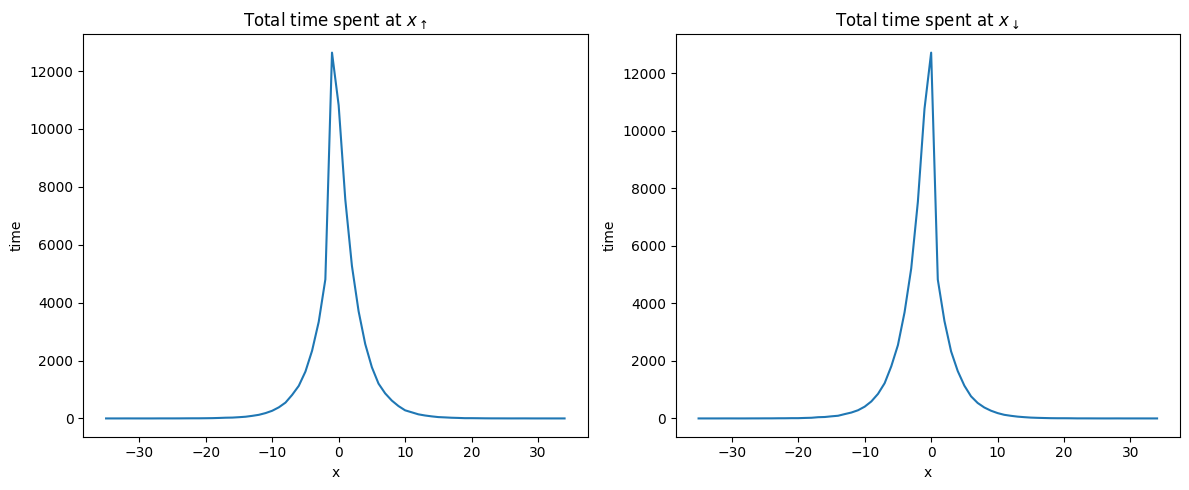

In [ ]:
n = int(1e6)
Z, jumps = X(n)
grid_up, grid_down, xmax = total_time(Z, jumps)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for x_up
ax[0].plot(range(-xmax, xmax), grid_up)
ax[0].set_title('Total time spent at $x_{\\uparrow}$')
ax[0].set_xlabel('x')
ax[0].set_ylabel('time')

# Plot for x_down
ax[1].plot(range(-xmax, xmax), grid_down)
ax[1].set_title('Total time spent at $x_{\\downarrow}$')
ax[1].set_xlabel('x')
ax[1].set_ylabel('time')

#graphs total time spent at each element of E
plt.tight_layout()
plt.show()

In [ ]:
# implements the stationary measure pi we calculated
def pi_init(xmax, x0_up=1):
    pi_up=np.zeros(xmax) # for x>=0
    pi_down=np.zeros(xmax+1) # for x>=1

    #initializing start value
    pi_up[0]=x0_up
    pi_down[1]=pi_up[0]*(alpha+beta)/(alpha+gamma) # we ignore the value at index 0 for a better correspondance with previous formulas
    pi_down[2]=-beta/eta*pi_up[0]+(gamma+alpha)/eta*pi_down[1]

    #initilizing constants for simpler notation
    eps=alpha/(alpha+beta)
    zeta=(eta+gamma)/eta

    #pi_up loop
    for x in range(1, xmax):
        sum1=0
        for y in range(1,x+1):
            sum1+=(zeta**(y-1))*eps**(x-y)
        sum2=0
        for y in range(2,x+1):
            sub_sum=0
            for z in range(y,x+1):
                sub_sum+=(eps**(x-z))*zeta**(z-y)
            sum2+=pi_up[y-1]*sub_sum
        pi_up[x]=pi_up[0]*eps**x + pi_down[2]*gamma/(alpha+beta)*sum1 -gamma*beta/(eta*(alpha+beta))*sum2

    #pi_down loop
    for x in range(3,xmax+1):
        sum=0
        for y in range(2,x):
            sum+=pi_up[y-1]*zeta**(x-1-y)
        pi_down[x]=pi_down[2]*zeta**(x-2)-beta/eta*sum
    pi_down=pi_down[1:]

    #returning arrays
    pi_up_final=np.concatenate(((pi_down)[::-1],pi_up),axis=None)
    pi_down_final=np.concatenate((pi_up[::-1],pi_down),axis=None)
    return pi_up_final,pi_down_final


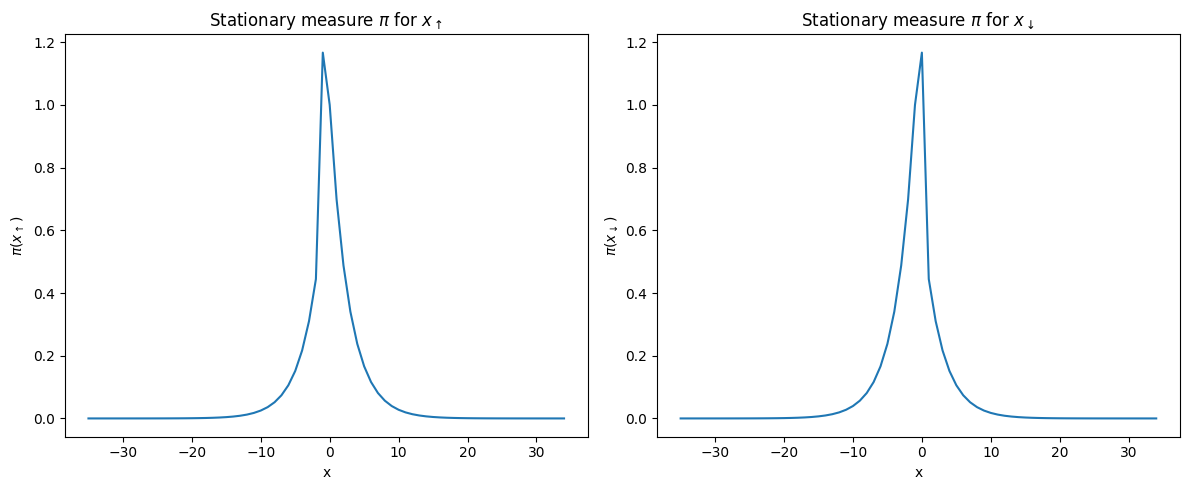

In [ ]:
# graphing pi
pi_up,pi_down=pi_init(xmax)
ran=np.arange(-xmax,xmax)

fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# plot for x_up
ax[0].plot(ran,pi_up)
ax[0].set_title('Stationary measure $\pi$ for $x_{\\uparrow}$')
ax[0].set_xlabel('x')
ax[0].set_ylabel('$\pi(x_{\\uparrow})$')

ax[1].plot(ran,pi_down)
ax[1].set_title('Stationary measure $\pi$ for $x_{\\downarrow}$')
ax[1].set_xlabel('x')
ax[1].set_ylabel('$\pi(x_{\\downarrow})$')

plt.tight_layout()
plt.show()

In [ ]:
# function to normalise the average time & pi
def normalizer(grid_up,grid_down):
  h=grid_up.sum()+grid_down.sum()
  return grid_up/h,grid_down/h

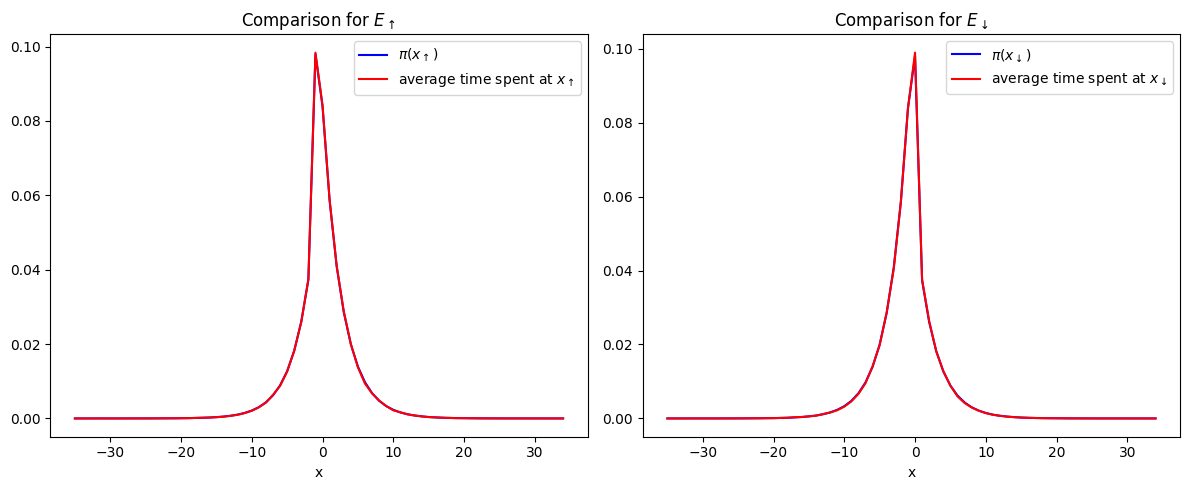

In [ ]:
# Pi compared to the simulation:

#normalizing both arrays:
pi_up,pi_down=normalizer(pi_up,pi_down)
grid_up,grid_down=normalizer(grid_up,grid_down)

ran=np.arange(-xmax,xmax)
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].plot(ran,pi_up,color='b', label='$\pi(x_{\\uparrow})$')
ax[0].plot(ran,grid_up,color='r',label='average time spent at $x_{\\uparrow}$')
ax[0].set_title('Comparison for $E_{\\uparrow}$')
ax[0].set_xlabel('x')
ax[0].legend(loc='best')

ax[1].plot(ran,pi_down,color='b',label='$\pi(x_{\\downarrow})$')
ax[1].plot(ran,grid_down,color='r',label='average time spent at $x_{\\downarrow}$')
ax[1].set_title('Comparison for $E_{\\downarrow}$')
ax[1].set_xlabel('x')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

We can see that both curves are indistinguishable by the naked eye, evidence that we have correctly calculated and implemented the stationary measure.

---------------------------------------------------------
Finally, we compute an absolute error of the ergodic behavior described above (on a finite number of states), i.e. we compute the following object:

$$
\sum_{x=-x_{max}}^{x_{max-1}}\left|\pi(x\uparrow)-\frac{1}{T}\int_{0}^{T}𝟙_{X_{t}=x}\text{d}t\right|+\sum_{x=-x_{max}+1}^{x_{max}}\left|\pi(x↓)-\frac{1}{T}\int_{0}^{T}𝟙_{X_{t}=x}\text{d}t\right|
$$


In [ ]:
diff_up=abs(pi_up-grid_up)
diff_down=abs(pi_down-grid_down)
print(diff_up.sum()+diff_down.sum())

0.007795525201738764
